# Port Congestion Prediction Model Training

Trains a LightGBM model to predict port waiting times at bulk carrier discharge ports.

**Target Ports:** Qingdao, Rizhao, Caofeidian, Fangcheng (China), Mundra, Vizag (India)

**Note:** For full training, use `python scripts/train_model.py` instead.

In [1]:
import os
import sys

# Setup paths
NOTEBOOK_DIR = os.path.dirname(os.path.abspath('__file__'))
PROJECT_ROOT = os.path.dirname(NOTEBOOK_DIR) if 'notebooks' in NOTEBOOK_DIR else NOTEBOOK_DIR
SRC_DIR = os.path.join(PROJECT_ROOT, 'src')
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
RAW_DATA_DIR = os.path.join(DATA_DIR, 'raw')
MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')

if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print(f"Project root: {PROJECT_ROOT}")

Project root: c:\Users\sidha\Code\Projects\Cargill BIA\cargill_datathon_submission\cargill_datathon


## 1. Data Loading

In [2]:
# Load data
print("Loading port activity data...")
activity_df = pd.read_csv(os.path.join(RAW_DATA_DIR, 'Daily_Port_Activity_Data_and_Trade_Estimates.csv'))
print(f"Loaded {len(activity_df):,} rows")

ports_df = pd.read_csv(os.path.join(DATA_DIR, 'PortWatch_ports_database.csv'))
print(f"Loaded {len(ports_df):,} ports")

Loading port activity data...
Loaded 5,010,140 rows
Loaded 1,985 ports


In [3]:
# Target ports
TARGET_PORTS = {
    'port1069': 'Qingdao',
    'port1105': 'Rizhao',
    'port339': 'Fangcheng',
    'port1266': 'Caofeidian',
    'port777': 'Mundra',
    'port1367': 'Vizag',
}

# Filter to target ports
target_df = activity_df[activity_df['portid'].isin(TARGET_PORTS.keys())].copy()
target_df['date'] = pd.to_datetime(target_df['date'])
target_df = target_df.sort_values(['portid', 'date'])

print(f"Filtered to {len(target_df):,} rows")
print(f"Date range: {target_df['date'].min().date()} to {target_df['date'].max().date()}")

Filtered to 15,144 rows
Date range: 2019-01-01 to 2025-11-28


## 2. Exploratory Data Analysis

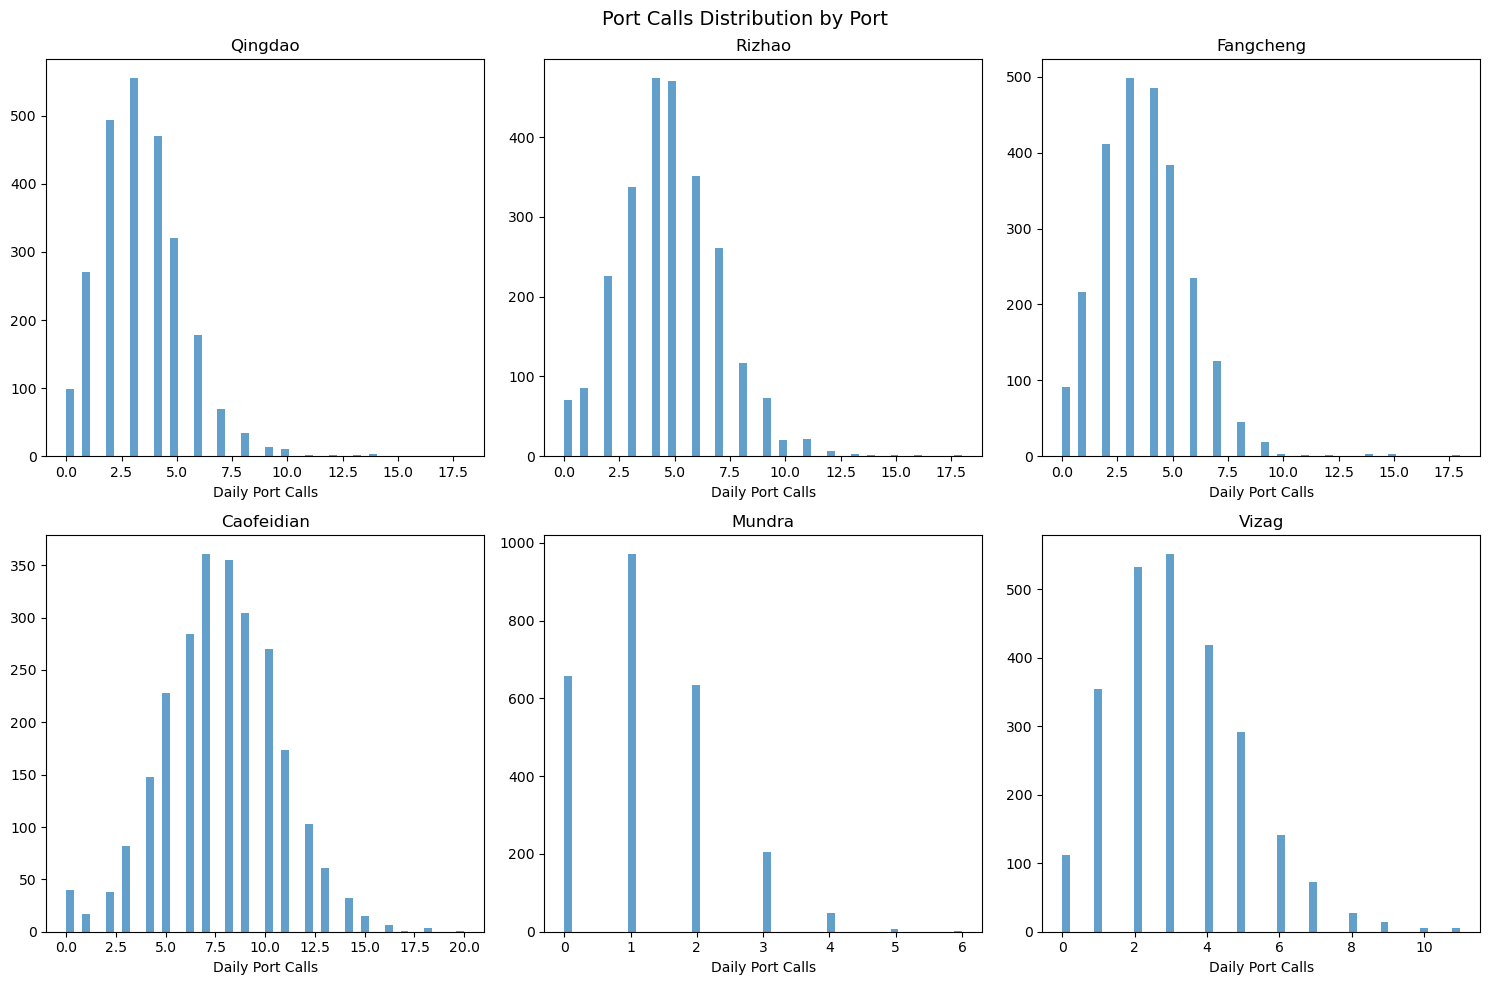

In [4]:
# Port calls distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (port_id, port_name) in enumerate(TARGET_PORTS.items()):
    port_data = target_df[target_df['portid'] == port_id]
    axes[idx].hist(port_data['portcalls_dry_bulk'], bins=50, alpha=0.7)
    axes[idx].set_title(f'{port_name}')
    axes[idx].set_xlabel('Daily Port Calls')

plt.suptitle('Port Calls Distribution by Port', fontsize=14)
plt.tight_layout()
plt.show()

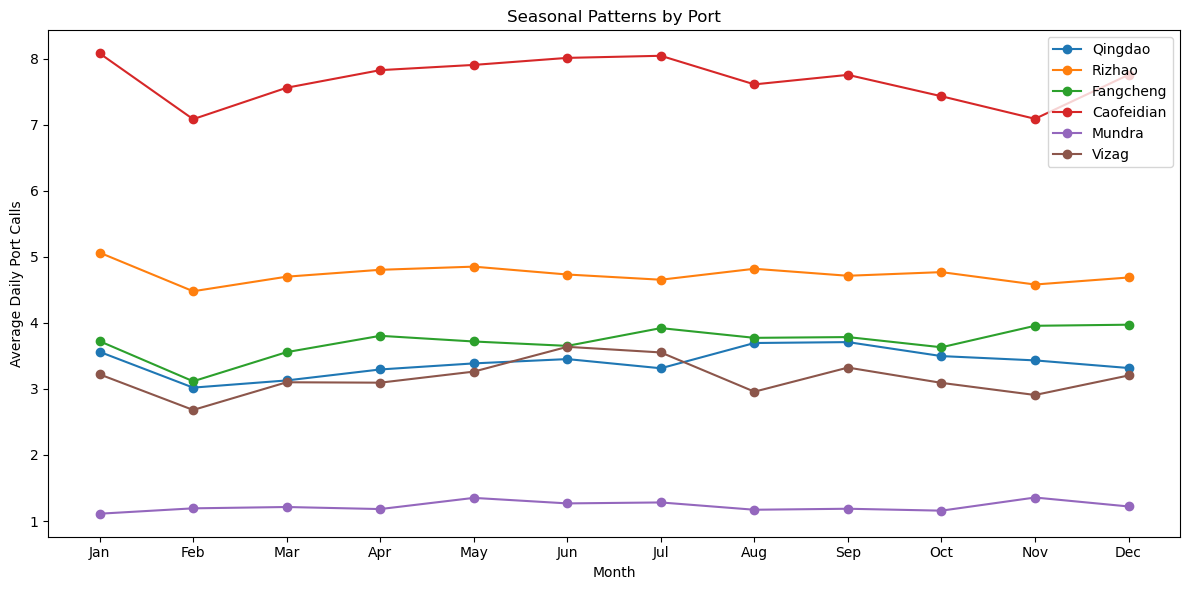

In [5]:
# Monthly seasonality
target_df['month'] = target_df['date'].dt.month
monthly_avg = target_df.groupby(['portid', 'month'])['portcalls_dry_bulk'].mean().reset_index()

plt.figure(figsize=(12, 6))
for port_id, port_name in TARGET_PORTS.items():
    data = monthly_avg[monthly_avg['portid'] == port_id]
    plt.plot(data['month'], data['portcalls_dry_bulk'], marker='o', label=port_name)

plt.xlabel('Month')
plt.ylabel('Average Daily Port Calls')
plt.title('Seasonal Patterns by Port')
plt.legend()
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

## 3. Feature Engineering & Model Training

For full training with all features, use the script:
```bash
python scripts/train_model.py
```

In [6]:
from ml.feature_engineering import FeatureEngineer
from ml.holiday_calendar import HolidayCalendar

feature_engineer = FeatureEngineer(os.path.join(DATA_DIR, 'PortWatch_ports_database.csv'))

# Create features for one port as example
port_data = target_df[target_df['portid'] == 'port1069'].copy()
port_data = port_data.sort_values('date')
port_data['delay_days'] = feature_engineer.create_target_variable(port_data, 'port1069')

features_df = feature_engineer.engineer_features(port_data, 'port1069', include_target=True)
print(f"Created {len(features_df.columns)} features for {len(features_df)} rows")

Created 68 features for 2524 rows


In [7]:
# Show feature columns
feature_cols = feature_engineer.get_feature_columns()
print("Feature columns:")
for col in feature_cols:
    print(f"  - {col}")

Feature columns:
  - portcalls_dry_bulk_lag7
  - portcalls_dry_bulk_lag14
  - portcalls_dry_bulk_lag30
  - portcalls_dry_bulk_rolling7_mean
  - portcalls_dry_bulk_rolling7_std
  - portcalls_dry_bulk_rolling14_mean
  - portcalls_dry_bulk_rolling14_std
  - portcalls_dry_bulk_rolling30_mean
  - portcalls_dry_bulk_rolling30_std
  - import_dry_bulk_rolling7_mean
  - import_dry_bulk_rolling7_sum
  - import_dry_bulk_rolling30_sum
  - import_dry_bulk_momentum
  - feat_day_of_week
  - feat_month
  - feat_week_of_year
  - feat_quarter
  - feat_is_weekend
  - is_cny
  - cny_proximity_days
  - is_golden_week
  - is_monsoon_india
  - is_diwali
  - port_capacity_ratio
  - is_china
  - is_india


## 4. Test Trained Model

In [8]:
# Test the predictor with saved model
from ml.port_congestion_predictor import PortCongestionPredictor

model_path = os.path.join(MODELS_DIR, 'port_delay_v1.joblib')

if os.path.exists(model_path):
    predictor = PortCongestionPredictor(
        model_path=model_path,
        data_path=os.path.join(RAW_DATA_DIR, 'Daily_Port_Activity_Data_and_Trade_Estimates.csv'),
        port_database_path=os.path.join(DATA_DIR, 'PortWatch_ports_database.csv')
    )
    print(f"Model available: {predictor.is_model_available()}")
    
    # Test predictions
    test_ports = ['Qingdao', 'Rizhao', 'Mundra', 'Vizag']
    test_date = '2026-03-15'
    
    print(f"\nPredictions for {test_date}:")
    for port in test_ports:
        result = predictor.predict(port, test_date)
        print(f"  {port}: {result.predicted_delay_days:.1f} days ({result.congestion_level})")
else:
    print(f"Model not found at {model_path}")
    print("Run: python scripts/train_model.py")

Model available: True

Predictions for 2026-03-15:
  Qingdao: 1.5 days (low)
  Rizhao: 2.3 days (medium)
  Mundra: 4.0 days (medium)
  Vizag: 1.0 days (low)


## 5. SHAP Analysis (if model exists)

SHAP Feature Importance:


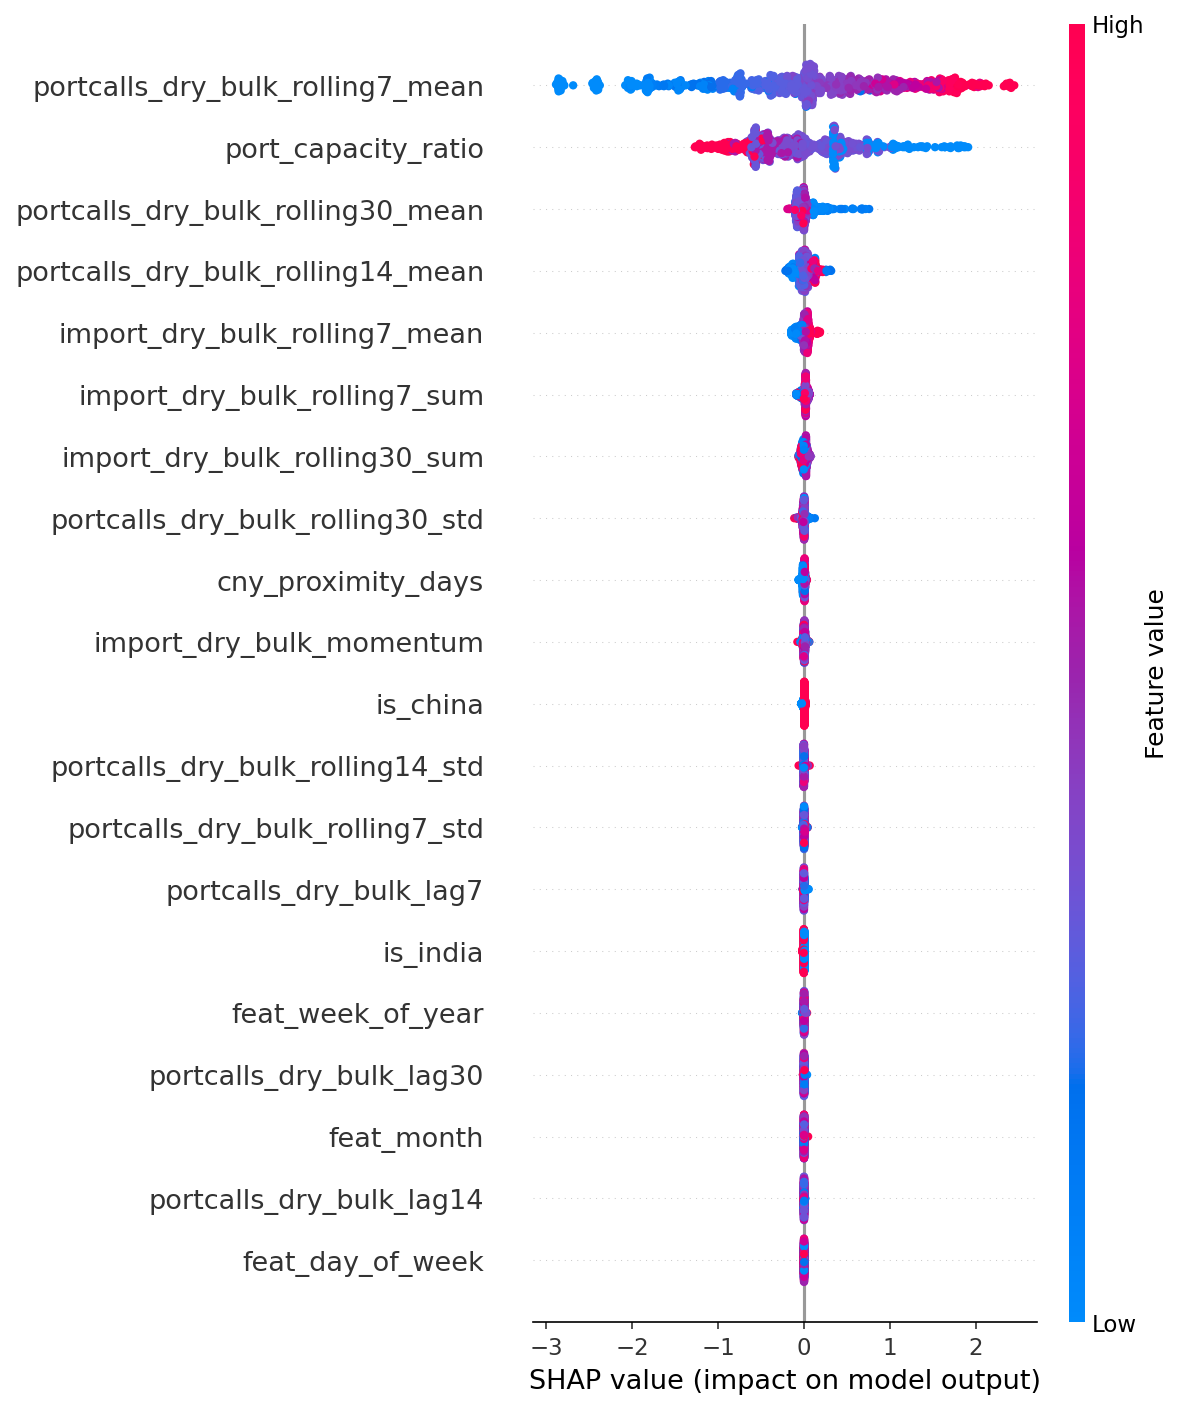

In [9]:
# Check for SHAP plot
shap_plot_path = os.path.join(MODELS_DIR, 'shap_summary.png')

if os.path.exists(shap_plot_path):
    from IPython.display import Image, display
    print("SHAP Feature Importance:")
    display(Image(filename=shap_plot_path))
else:
    print("SHAP plot not found. Run: python scripts/train_model.py")

## Summary

**Model outputs:**
- `models/port_delay_v1.joblib` - Trained LightGBM model
- `models/model_info.json` - Model metadata and metrics
- `models/shap_summary.png` - SHAP feature importance plot

**Usage:**
```python
from src.ml import PortCongestionPredictor

predictor = PortCongestionPredictor('models/port_delay_v1.joblib')
delay = predictor.get_delay_for_voyage('Qingdao', '2026-03-15')
```